# Homework 2 - IEEE Fraud Detection


![kaggle_profile](https://user-images.githubusercontent.com/8913742/65657680-6c166f00-dff2-11e9-98db-b9e25eaebc07.png)

**Importing required libraries**

In [0]:
'''
******************************************************************************
  CSE-519-Data Science Fundamentals HW2
  Name: Rishabh Goel
  SBU Id : 112714848
  Email Id: rishabh.goel@stonybrook.edu
  Kaggle profile link : https://www.kaggle.com/rishabhgoelsbu
*******************************************************************************
'''

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns              # plotting libraries
import matplotlib.pyplot as plt

import datetime                   # for working with dates
import matplotlib.dates as mdates

import csv                        # for saving from and loading to colab
from google.colab import files

from sklearn.model_selection import train_test_split   #data preprocessing 
from sklearn.preprocessing import LabelEncoder
  
from xgboost              import XGBClassifier          # model libraries
from sklearn.ensemble     import ExtraTreesClassifier
from sklearn.tree         import ExtraTreeClassifier
from sklearn.tree         import DecisionTreeClassifier
from sklearn.ensemble     import GradientBoostingClassifier
from sklearn.ensemble     import BaggingClassifier
from sklearn.ensemble     import AdaBoostClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm             import LGBMClassifier

import pickle          # to save model

from sklearn.metrics import roc_auc_score   # for result analysis
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report

**Loading data from google drive to colab**

In [0]:
#Reference : https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
    
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# read csv from google drive
def readcsv(link,filename,col=None):
  fluff, id = link.split('=')
  print (id) # Verify that you have everything after '='
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)
  return pd.read_csv(filename,index_col=col)

In [0]:
train_transaction_link ='https://drive.google.com/open?id=12Kzyh6gWTYcutdYGVxKJOysE5cB3maBg'
train_identity_link = 'https://drive.google.com/open?id=16mIyAHo6XRoFsTae1UwZKzVl2ZrqZHYh'
test_transaction_link = 'https://drive.google.com/open?id=1e7_dC83nyScSdTckoUuK8x2q2oyWG-OP'
test_identity_link = 'https://drive.google.com/open?id=1gcmBSZscID4-yyBCpV9OQSCusmcxu3Re'
sample_submission_link = 'https://drive.google.com/open?id=1QMOdzJBw4cn0IfqBNQ33YmrZvJaYMnRd'

In [10]:
#train transaction data
train_data_tr = readcsv(train_transaction_link,'train_transaction.csv')
#train identity data
train_data_id = readcsv(train_identity_link,'train_identity.csv')
#test transaction data
test_data_tr = readcsv(test_transaction_link,'test_transaction.csv')
#test identity data
test_data_id = readcsv(test_identity_link,'test_identity.csv')
#sample submission
sample_submission = readcsv(sample_submission_link,'sample_submission.csv','TransactionID')

16mIyAHo6XRoFsTae1UwZKzVl2ZrqZHYh
1e7_dC83nyScSdTckoUuK8x2q2oyWG-OP
1gcmBSZscID4-yyBCpV9OQSCusmcxu3Re
1QMOdzJBw4cn0IfqBNQ33YmrZvJaYMnRd


**Studying data**

In [0]:
# Merging transaction and identity data
train_data = pd.merge(train_data_tr, train_data_id, on='TransactionID', how='left')
test_data = pd.merge(test_data_tr, test_data_id, on='TransactionID', how='left')

In [12]:
# Peeking into train transaction data
print(train_data.shape)
train_data_tr.head()

(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Using the following features for the first 5 questions
features1_5 = ['TransactionID','DeviceType','DeviceInfo','TransactionDT',
               'TransactionAmt','ProductCD','card4','card6','P_emaildomain',
               'R_emaildomain','addr1','addr2','dist1','dist2','isFraud']
train_data1_5 = train_data[features1_5]
print(train_data1_5.describe())
train_data1_5.head()

       TransactionID  TransactionDT  ...         dist2        isFraud
count   5.905400e+05   5.905400e+05  ...  37627.000000  590540.000000
mean    3.282270e+06   7.372311e+06  ...    231.855423       0.034990
std     1.704744e+05   4.617224e+06  ...    529.053494       0.183755
min     2.987000e+06   8.640000e+04  ...      0.000000       0.000000
25%     3.134635e+06   3.027058e+06  ...      7.000000       0.000000
50%     3.282270e+06   7.306528e+06  ...     37.000000       0.000000
75%     3.429904e+06   1.124662e+07  ...    206.000000       0.000000
max     3.577539e+06   1.581113e+07  ...  11623.000000       1.000000

[8 rows x 8 columns]


,TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2,isFraud
0,2987000,NaN,NaN,86400,68.5,W,discover,credit,NaN,NaN,315.0,87.0,19.0,NaN,0
1,2987001,NaN,NaN,86401,29.0,W,mastercard,credit,gmail.com,NaN,325.0,87.0,NaN,NaN,0
2,2987002,NaN,NaN,86469,59.0,W,visa,debit,outlook.com,NaN,330.0,87.0,287.0,NaN,0
3,2987003,NaN,NaN,86499,50.0,W,mastercard,debit,yahoo.com,NaN,476.0,87.0,NaN,NaN,0
4,2987004,mobile,SAMSUNG SM-G892A Build/NRD90M,86506,50.0,H,mastercard,credit,gmail.com,NaN,420.0,87.0,NaN,NaN,0


## Part 0 - Data Preprocessing (Q:1-5)

---



In [0]:
from sklearn import preprocessing
def normalize(data):    
    #Create x, where x the 'scores' column's values as floats
    x = data.values.astype(float)

    # Create a minimum and maximum processor object
    min_max_scaler = preprocessing.Normalizer()

    # Create an object to transform the data to fit minmax processor
    x_scaled = min_max_scaler.fit_transform(x)
    # Run the normalizer on the dataframe
    normalized_data = pd.DataFrame(x_scaled)
    return normalized_data


In [0]:
startdate = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')

# converting timestamp to yyyy-mm-dd format
train_data1_5['TransactionDT_date'] = train_data1_5['TransactionDT'].apply(
    lambda x: (startdate + datetime.timedelta(seconds = x)))

# converting timestamp to hour of day format
#train_data1_5['TransactionDT_time'] = train_data1_5.TransactionDT_date.apply
#                                       (lambda x:  1+((x.hour+15)%24))
train_data1_5['TransactionDT_time'] = train_data1_5.TransactionDT_date.apply(
    lambda x: x.hour)

#making a new feature to find info about decimal length of the transaction amount,
#since it has been observed that frauds mostly occur through high decimal length transactions.
train_data1_5['TransactionAmt_decimal_length'] = train_data1_5['TransactionAmt'].astype(
    str).str.split('.', expand=True)[1].str.len()

#Visualizing outliers
train_data1_5.loc[train_data1_5['TransactionAmt']>=8000]

#Removing outliers
train_data1_5 = train_data1_5[train_data1_5['TransactionAmt']<=10000]


In [0]:
# Utility function to process categorical data and cat code it
def process_categorical(feature):
    train_data1_5[feature].describe()
    train_data1_5[feature] = train_data1_5[feature].astype('category')
    train_data1_5[feature+'_cat'] = train_data1_5[feature].cat.codes
    train_data1_5.dtypes
    d = dict(enumerate(train_data1_5[feature].cat.categories))
    print (d)

In [17]:
#preprocessing categorical data

process_categorical('DeviceType')
process_categorical('ProductCD')
process_categorical('card4')
process_categorical('card6')
process_categorical('P_emaildomain')
process_categorical('R_emaildomain')
train_data1_5['P_emaildomain'].describe()
train_data1_5['R_emaildomain'].describe()

{0: 'desktop', 1: 'mobile'}
{0: 'C', 1: 'H', 2: 'R', 3: 'S', 4: 'W'}
{0: 'american express', 1: 'discover', 2: 'mastercard', 3: 'visa'}
{0: 'charge card', 1: 'credit', 2: 'debit', 3: 'debit or credit'}
{0: 'aim.com', 1: 'anonymous.com', 2: 'aol.com', 3: 'att.net', 4: 'bellsouth.net', 5: 'cableone.net', 6: 'centurylink.net', 7: 'cfl.rr.com', 8: 'charter.net', 9: 'comcast.net', 10: 'cox.net', 11: 'earthlink.net', 12: 'embarqmail.com', 13: 'frontier.com', 14: 'frontiernet.net', 15: 'gmail', 16: 'gmail.com', 17: 'gmx.de', 18: 'hotmail.co.uk', 19: 'hotmail.com', 20: 'hotmail.de', 21: 'hotmail.es', 22: 'hotmail.fr', 23: 'icloud.com', 24: 'juno.com', 25: 'live.com', 26: 'live.com.mx', 27: 'live.fr', 28: 'mac.com', 29: 'mail.com', 30: 'me.com', 31: 'msn.com', 32: 'netzero.com', 33: 'netzero.net', 34: 'optonline.net', 35: 'outlook.com', 36: 'outlook.es', 37: 'prodigy.net.mx', 38: 'protonmail.com', 39: 'ptd.net', 40: 'q.com', 41: 'roadrunner.com', 42: 'rocketmail.com', 43: 'sbcglobal.net', 44: '

count        137291
unique           60
top       gmail.com
freq          57147
Name: R_emaildomain, dtype: object

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

(590538, 24)
(20663, 24)
(569875, 24)


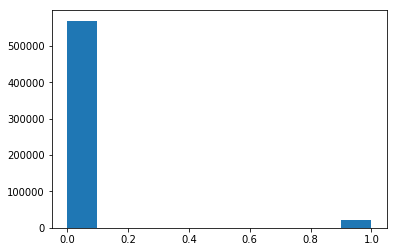

In [18]:
print(train_data1_5.shape)
# Segregating train data into fraudelent and non fraudelent data

train_data1_5_fraud = train_data1_5.loc[train_data1_5['isFraud'] == 1]
train_data1_5_not_fraud = train_data1_5.loc[train_data1_5['isFraud'] == 0]
print(train_data1_5_fraud.shape)
print(train_data1_5_not_fraud.shape)
plt.hist(train_data1_5['isFraud'])
plt.show()

This data seems to be imbalanced. Only ~20k fraudelent transactions as compared to ~0.5 million non-fraudelent transactions.

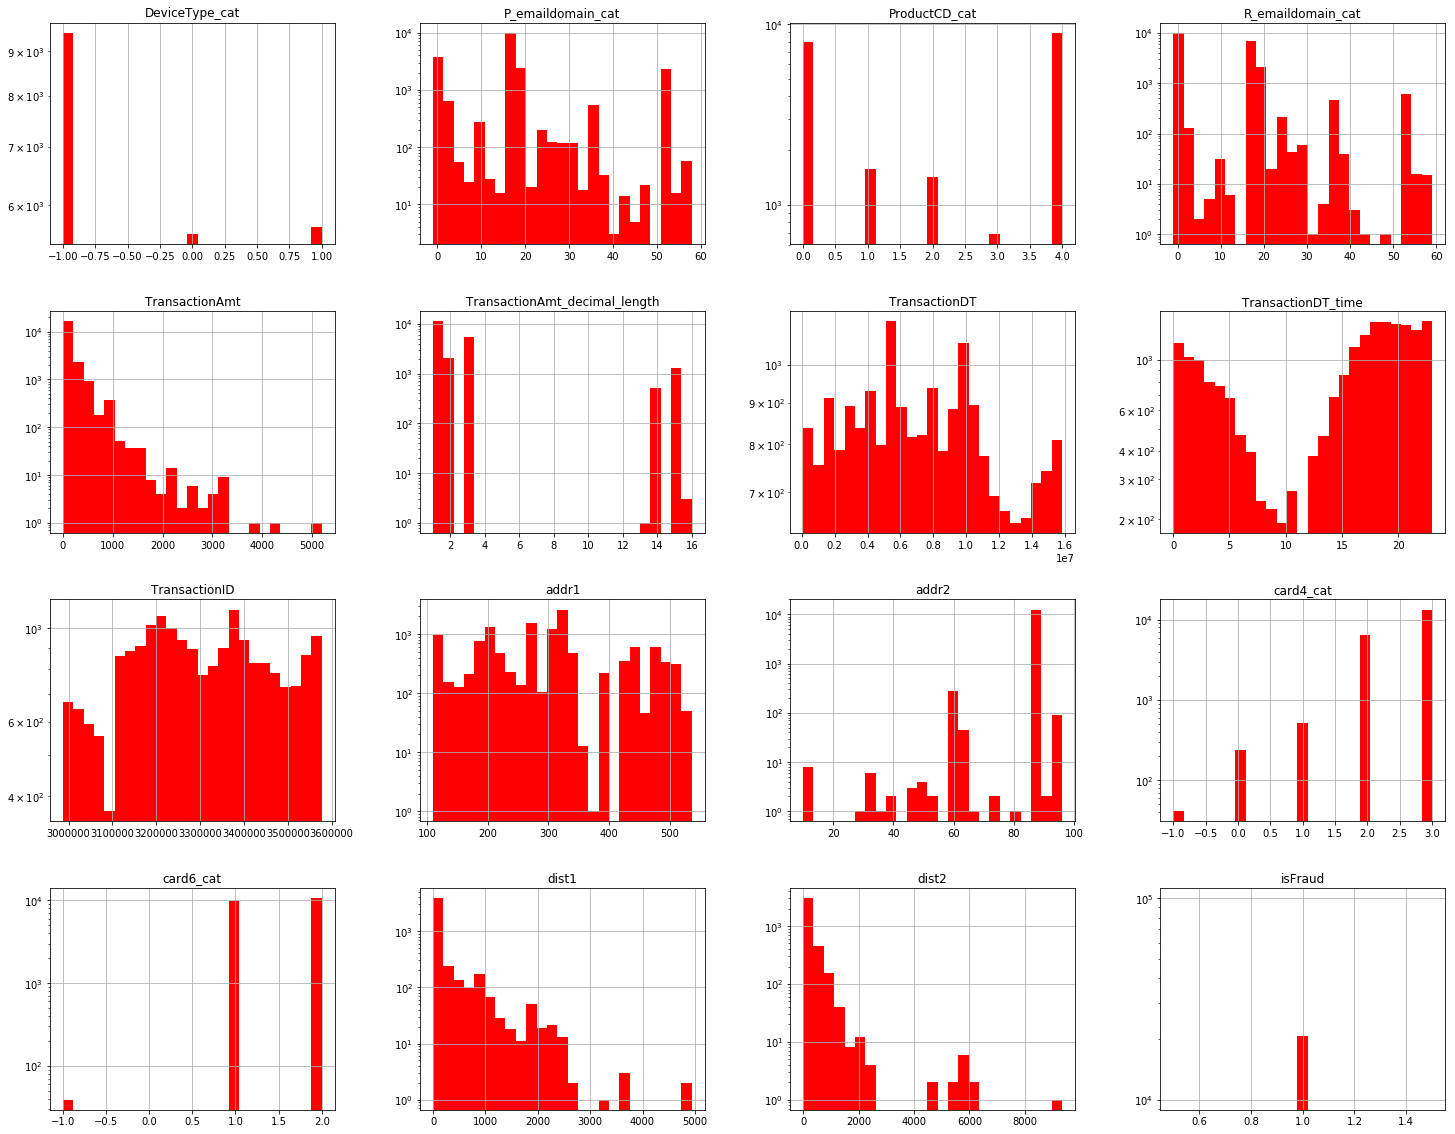

In [20]:
hist = train_data1_5_fraud.hist(bins=25,figsize=(25,20),log=True,color='r')

# **Plotting given features distribution for fraudelent transactions**
From the above plots, I am able to make the following observations:


*   There are many null values for device_type. Whatever values we have, it seems fraudelent transactions are made using mobile more than desktop.

*   Fraudelent transactions are more for product code 'C' and 'W'.

*   Fraudelent transactions are generally for small transaction amounts and the probability decreases as we move on to higher value transactions. From above graph, most of them are in the range of [0,1650]

*   TransactionDT is not giving much clue, so we plot TransactionDT_time (hour of the day) and we observe except for a small window , say [6,13], fraudelent transactions are frequent, but we should not jump to conclusion. That might just indicate the waking hours of people.

*   addr2 shows some value near 90 (specifically 87), which has considerable amount of fraud transactions, but again, that might be true for whole data overall.

All above observations are actually incomplete (maybe wrong too) without examining non-fraudelent data. So let's examine that.





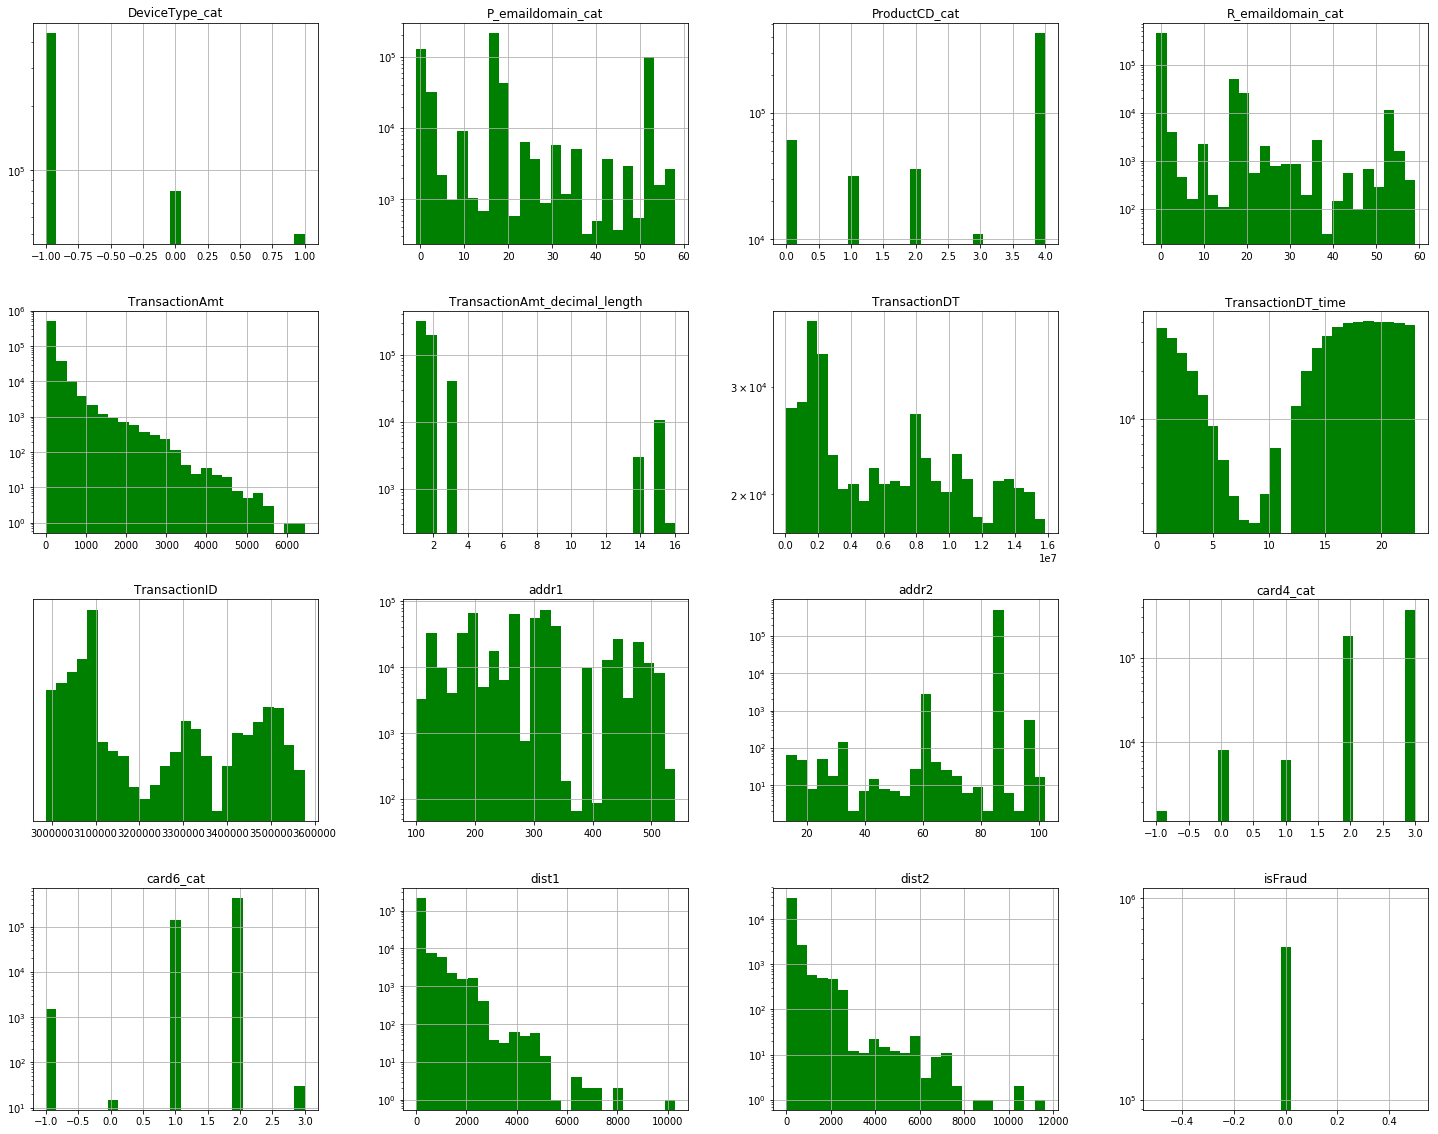

In [21]:
hist = train_data1_5_not_fraud.hist(bins=25,figsize=(25,20),log=True,color='g')

# **Plotting given features distribution for non-fraudelent transactions**
Now we can compare fraudelent and non-fraudelent plots and make some concrete observations:


*   Our previous observation about device_type seems to be correct. Desktop is less prone to fraudelent transactions than **mobile** it seems. This might be an important feature going forward.

*   We observe that 'W' product code has high frequency for non-fraudelent data too but we can observe a correlation between **product code 'C'** and fraudelent transactions.

*   TransactionDT_time, TransactionAmt, addr2 show same pattern for non-fraudelent as fraudelent, so it is not incorrect to say that they don't tell much about fraudelent transactions as of now, but they tell some general idea about the whole data. For eg :


1.   The sleeping hours seem to be somewhere around **[5-11]**.
2.   The data comes dominantly from one country whose code is **87** here.
3.   The transaction amount ranges predominantly from **0-5000**, with **0-1000** having the most frequency , which seems plausible as, generally people shop in that range.






## Part 2 - Transaction Frequency


In [0]:
def plotbyFrequentCountry(data):
  #Extracting the data for max occuring country
  train_freq_country = data.loc[data['addr2']==87.0]
  train_freq_country.dropna(subset= ['TransactionDT_time'])
  return train_freq_country

The most frequently occuring country code in data is : 87.0


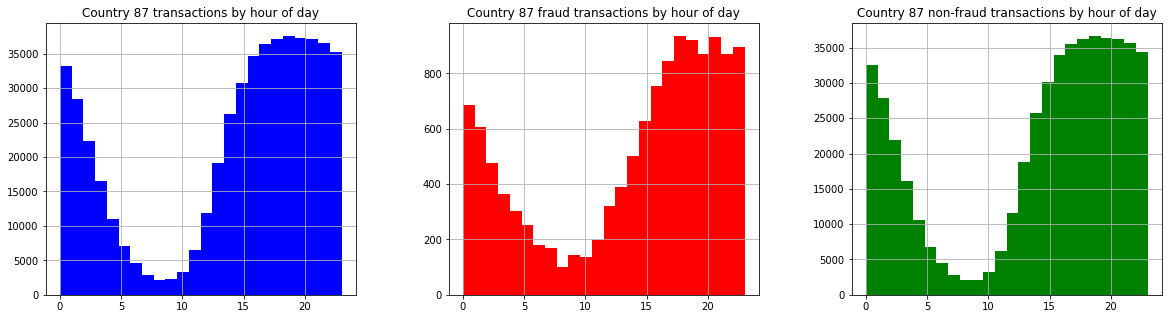

In [23]:
print('The most frequently occuring country code in data is :',train_data1_5['addr2'].
      value_counts().idxmax())

fig, axes = plt.subplots(1, 3,figsize=(20,5))
plotbyFrequentCountry(train_data1_5).hist('TransactionDT_time',
                                          bins=24, ax=axes[0],color='b')
axes[0].set_title('Country 87 transactions by hour of day')
plotbyFrequentCountry(train_data1_5_fraud).hist('TransactionDT_time',
                                                bins=24, ax=axes[1],color='r')
axes[1].set_title('Country 87 fraud transactions by hour of day')
plotbyFrequentCountry(train_data1_5_not_fraud).hist('TransactionDT_time',
                                                    bins=24, ax=axes[2],color='g')
axes[2].set_title('Country 87 non-fraud transactions by hour of day')
plt.show()

## Observations - Part 2

*   It is evident from the plots that the period [5-11] is sleeping hours for country 87. Other times have sufficient transactions to label them as waking hours.
*   Also, if we compare the fraud transactions plot with the other two plots, we can observe that relative occurence of fraudelent transactions at sleeping hours is more than non fraudelent transactions.


Note : These are relative values and don't actually tell anything about the timezone of the country.

## Part 3 - Product Code

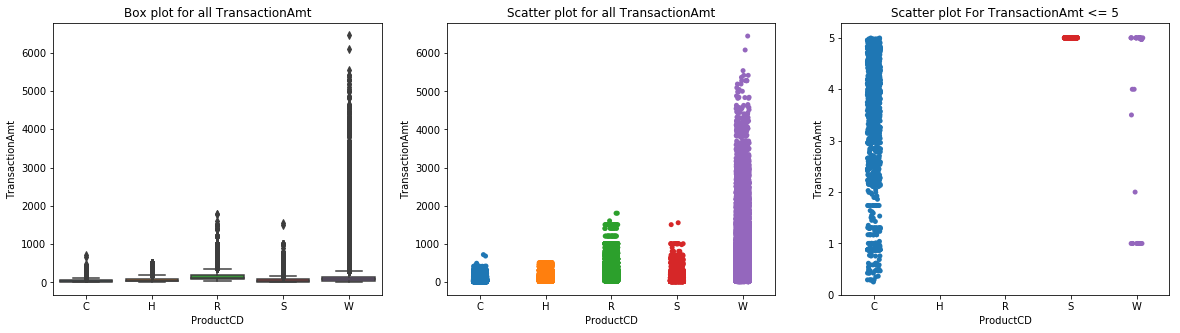

In [24]:
fig, axes = plt.subplots(1, 3,figsize=(20,5))
sns.catplot(x="ProductCD", y="TransactionAmt", kind="box",
            data=train_data1_5,sharey=False,ax=axes[0]);
axes[0].set_title('Box plot for all TransactionAmt')
sns.catplot(x="ProductCD", y="TransactionAmt",
            data=train_data1_5,sharey=False,ax=axes[1]);
axes[1].set_title('Scatter plot for all TransactionAmt')
train_data1_5_cheapest = train_data1_5.loc[train_data1_5['TransactionAmt']<=5.0]
sns.catplot(x="ProductCD", y="TransactionAmt",
            data=train_data1_5_cheapest,sharey=False,ax=axes[2]);
axes[2].set_title('Scatter plot For TransactionAmt <= 5')
plt.close(2)
plt.close(3)
plt.close(4)
plt.show()

## Observations - Part 3
*Box plot* : 'R' seems to be having highest mean of transactionAmt values , but that doesn't clearly tell if its having the most expensive products.

*Scatter plot1* : Here, it is evident that '**W**' product code is associated with the **most** **expensive** products, but we still cannot judge which code has the least expensive ones.

*Scatter plot2* : This contains TransactionAmts <= 5.0 . Now, it is evident, that 'C' contains a lot of products valued less than <=5.0 as compared to the other product codes. Thus, '**C**' is associated with the **least** **expensive** products.

## Part 4 - Correlation Coefficient

0.04537096589856998

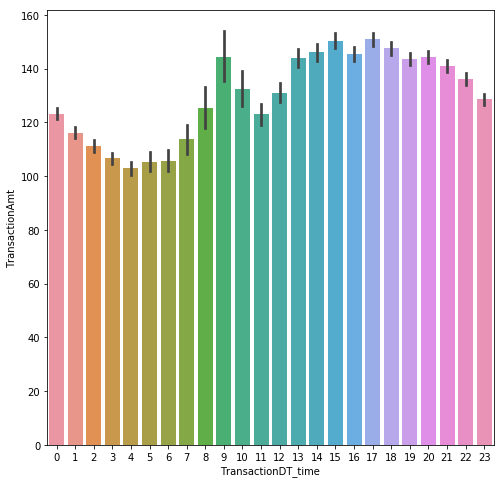

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
sns.catplot(x="TransactionDT_time", y="TransactionAmt" ,kind="bar", data=train_data1_5,ax=ax);
plt.close(2)
train_data1_5['TransactionDT_time'].corr(train_data1_5['TransactionAmt'])

Correlation coefficient comes out to be : **0.04537096589856998** <br>
The plot represents the mean purchase amount at every hour of day.


## Part 5 - Interesting Plot

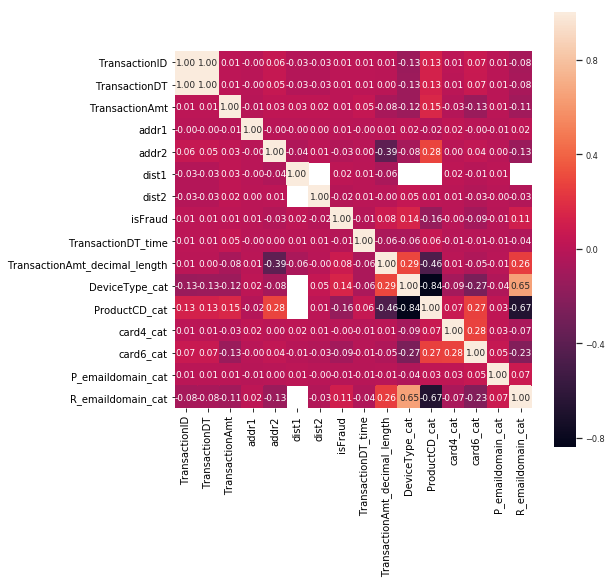

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=0.75)
corr = train_data1_5.loc[:,train_data1_5.dtypes != 'object'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cbar=True,
            annot=True, square=True, fmt='.2f',ax=ax)

## Interesting plot - 0

The heatmap is a good plot to try to start analyze a lot of features together. So keeping that in mind, I plotted heatmap of the given features for Q1-5. But the problem here is 'isFraud' doesn't seem to correlate well with the given features. We get high correlation between 'ProductCD' and 'DeviceType' though and also, there is some correlation between 'DeviceType' and 'card6'. Let's analyze these features wrt 'isFraud'.



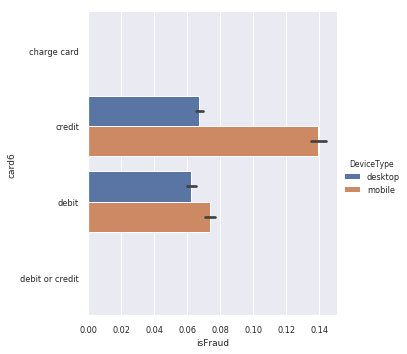

In [27]:
sns.catplot(x="isFraud", y="card6", hue="DeviceType",kind="bar", data=train_data1_5);

## Interesting plot - 1

After plotting several features which were highly correlated, I found this plot to be interesting.  <br>
The crux of this plot is that if transaction is done with credit card using a mobile, the probability of it being fraudelent is highest than other combos. It might have to do something with a bug or low security of the mobile app while doing credit card transactions.

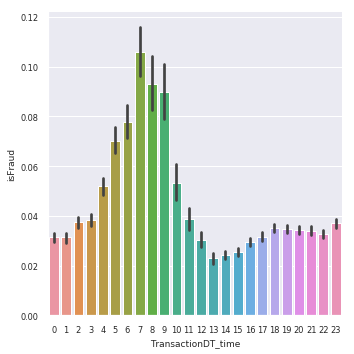

In [29]:
sns.catplot(x="TransactionDT_time", y="isFraud",kind="bar", data=train_data1_5);

## Interesting plot - 2

This plot is between the hour of day at which transaction was made and isFraud. <br>
We already observed the waking and sleeping hours in Part 2, which were [5-11] and if we look carefully, we observe that the chances of fraudelent transactions are higher during sleeping hours. This seems a really good indicator of the time when fraudelent transactions are expected to happen.

## Part 6 - Prediction Model

**6.1 Analyzing data**

In [0]:
# Peeking into train transaction data
print(train_data_tr.shape)
train_data_tr.head()

(590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Peeking into train identity data
print(train_data_id.shape)
train_data_id.head()

(144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [0]:
train_data_tr.isnull().sum()
train_data_id.isnull().sum()

TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

We have a lot of missing data in both transaction and id datasets.
Also, our class is imbalanced, since there are very less number of fraudelent transactions relative to the non fraudelent ones. (This was judged from plots in q1).

In [0]:
train_data['TransactionDT_date'] = train_data['TransactionDT'].apply(
    lambda x: (startdate + datetime.timedelta(seconds = x)))
test_data['TransactionDT_date'] = train_data['TransactionDT'].apply(
    lambda x: (startdate + datetime.timedelta(seconds = x)))

Text(0.5, 1.0, 'Distribution of TransactionDT variable')

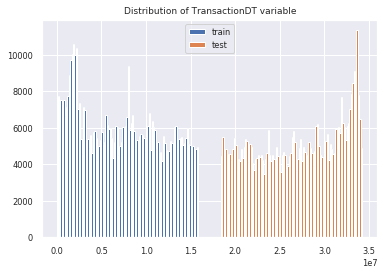

In [0]:
plt.hist(train_data['TransactionDT'],bins=100,label='train')
plt.hist(test_data['TransactionDT'],bins=100,label='test')
plt.legend()
plt.title('Distribution of TransactionDT variable')

train_data and test_data are given for different time periods and there seems to be some amount of gap between the two also.

**6.2 Preprocessing data**

In [0]:
#Separating the features and labels for train data
train_y = train_data['isFraud'].astype("uint8").copy()
train_x = train_data.drop('isFraud', axis=1)
print("TrainX: ",train_x.shape)

# Deleting dataframes that we no longer need
del train_data, train_data_tr, train_data_id

test_x = test_data.copy()
print("TestX: ",test_x.shape)

# Deleting dataframes that we no longer need
del test_data, test_data_tr, test_data_id

TrainX:  (590540, 434)
TestX:  (506691, 434)


In [0]:
# Label encoding non-numerical data, so it can fit into the model
for feature in train_x:
    if train_x[feature].dtype=='object' or test_x[feature].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_x[feature].values) + list(test_x[feature].values))
        train_x[feature] = lbl.transform(list(train_x[feature].values))
        test_x[feature] = lbl.transform(list(test_x[feature].values))

#No longer needed
train_x = train_x.drop(['TransactionDT_date'],axis=1)
test_x = test_x.drop(['TransactionDT_date'],axis=1)

In [0]:
train_x['TransactionAmt'] = np.log(train_x['TransactionAmt'])
test_x['TransactionAmt'] = np.log(test_x['TransactionAmt'])

#Repacing nan values with -1
train_x.fillna(-1,inplace=True)
test_x.fillna(-1,inplace=True)

In [0]:
def createFeat(base,feat):
  train_x[base+'_to_'+param+'_'+feat] = train_x[base]/train_x.groupby(
      [feat])[base].transform('mean')
  test_x[base+'_to_'+param+'_'+feat] = test_x[base]/test_x.groupby(
      [feat])[base].transform('mean')
  train_x[base+'_to_'+param+'_'+feat] = train_x[base]/train_x.groupby(
      [feat])[base].transform('std')
  test_x[base+'_to_'+param+'_'+feat] = test_x[base]/test_x.groupby(
      [feat])[base].transform('std')
  
createFeat('TransactionAmt','card1')
createFeat('TransactionAmt','card4')
createFeat('id_02','card1')
createFeat('id_02','card4')
createFeat('D15','card1')
createFeat('D15','card4')
createFeat('D15','addr1')
createFeat('D15','addr2')

#Repacing any newly created nan/inf values with -1
train_x = train_x.replace([np.inf, -np.inf,np.nan], -1)
test_x = test_x.replace([np.inf, -np.inf,np.nan], -1)

**6.3 Extracting important features**

In [0]:
def plot_feature_importances(clf, X_train, y_train=None, 
                             top_n=10, figsize=(20,10), title="Feature Importances"):
    __name__ = "plot_feature_importances"
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_train.values, y_train.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, LightGBMError, ValueError):
        clf.fit(X_train.values, y_train.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp1 = feat_imp
    feat_imp = feat_imp.iloc[:top_n]
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.bar(title=title, figsize=figsize)
    plt.hist(feat_imp)
    plt.xlabel('Feature Importance Score')
    plt.show()
    return feat_imp1
    

Here, I try to get the most important features for different classifiers using feature_importance, I save all this in their respective csvs , so I don't have to run it again and again. Then I use those rankings to extract the top 200 features across all classifiers and use them in my final model.
<br> <br>
Reference of plot_feature_importance function : https://www.kaggle.com/grfiv4/plotting-feature-importances


In [0]:
most_important_features = []
clfs = [XGBClassifier(),              LGBMClassifier(), 
        ExtraTreesClassifier(),       ExtraTreeClassifier(),
        BaggingClassifier(),          DecisionTreeClassifier(),
        GradientBoostingClassifier(), LogisticRegression(),
        AdaBoostClassifier(),         RandomForestClassifier()]

for clf in clfs:
    try:
        _ = plot_feature_importances(clf, train_x, train_y, top_n=200, 
                                     title=clf.__class__.__name__)
        most_important_features.append(_)
        print(most_important_features)
    except AttributeError as e:
        print(e)

'clfs = [XGBClassifier(),              LGBMClassifier(), \n        ExtraTreesClassifier(),       ExtraTreeClassifier(),\n        BaggingClassifier(),          DecisionTreeClassifier(),\n        GradientBoostingClassifier(), LogisticRegression(),\n        AdaBoostClassifier(),         RandomForestClassifier()]\n\nfor clf in clfs:\n    try:\n        _ = plot_feature_importances(clf, train_x, train_y, top_n=100, title=clf.__class__.__name__)\n        most_important_features.append(_)\n        print(most_important_features)\n    except AttributeError as e:\n        print(e)'

<img src = "https://user-images.githubusercontent.com/8913742/65647384-8b020a80-dfcc-11e9-9e27-ab785de35cb7.png" width=1500 height =500>
<img src = "https://user-images.githubusercontent.com/8913742/65647424-aa993300-dfcc-11e9-8f54-709d8529aaf3.png" width=1500 height =500>
<img src = "https://user-images.githubusercontent.com/8913742/65647429-aa993300-dfcc-11e9-9098-80a85a15b7a9.png" width=1500 height =500>
<img src = "https://user-images.githubusercontent.com/8913742/65647422-aa009c80-dfcc-11e9-801f-62717f7e9d93.png" width=1500 height =500>
<img src = "https://user-images.githubusercontent.com/8913742/65647428-aa993300-dfcc-11e9-8210-e50f365ee2cd.png" width=1500 height =500>
<img src = "https://user-images.githubusercontent.com/8913742/65647423-aa993300-dfcc-11e9-88e1-bd8e78b5a4b0.png" width=1500 height =500>
<img src = "https://user-images.githubusercontent.com/8913742/65647427-aa993300-dfcc-11e9-8785-4782de75f878.png" width=1500 height =500>
<img src = "https://user-images.githubusercontent.com/8913742/65647426-aa993300-dfcc-11e9-9923-114250698c37.png" width=1500 height =500>

In [0]:
# save features for each model
def storeResults(clf,filename):
  clf.to_csv(filename)
  files.download(filename)
    
# load features for each model  
def loadResults():
  for i in range(len(clfname)):
    temp = readcsv(filepath[i],clfname[i]+".csv")
    most_important_features.append(temp)
  
  
clfname = ['XGBClassifier','LGBMClassifier','ExtraTreesClassifier',
           'ExtraTreeClassifier','DecisionTreeClassifier','GradientBoostingClassifier',
           'AdaBoostClassifier','RandomForestClassifier']

# stored top features results for different classifiers in the following csv files/
filepath =[
    'https://drive.google.com/open?id=1x01Pz_MWaw_VlyQ5NehnibMPbSOeJePP',
    'https://drive.google.com/open?id=1WM7FNtVDxZQT_bMkS_DH5WUqULiDYLZU',
    'https://drive.google.com/open?id=1DPv1HMF_CXW1IYZycSGFJHztkDt5pesB',
    'https://drive.google.com/open?id=1a2MOdDwsIBGJohHUHFEQvWDdzJwzc5vq',
    'https://drive.google.com/open?id=1fTAPG66AKSLpaAiKWJ3DB82NK9wkIDwu',
    'https://drive.google.com/open?id=1b86pAR9XnHn1MXg3kq7DqYOSMDQheFuC',
    'https://drive.google.com/open?id=1caZW785BrHnzDfBhM9HTevjQsRFaEQ4y',
    'https://drive.google.com/open?id=108_1fw1pNdjiSsI6savKFhvp1Jk_AOU5'
]  


# Use the following loop when you run the model for the first time to store results,
#later comment it , and just load results.
#for i in range(len(clfname)):
#  storeResults(most_important_features[i],clfname[i]+'.csv')


loadResults()

1x01Pz_MWaw_VlyQ5NehnibMPbSOeJePP
1WM7FNtVDxZQT_bMkS_DH5WUqULiDYLZU
1DPv1HMF_CXW1IYZycSGFJHztkDt5pesB
1a2MOdDwsIBGJohHUHFEQvWDdzJwzc5vq
1fTAPG66AKSLpaAiKWJ3DB82NK9wkIDwu
1b86pAR9XnHn1MXg3kq7DqYOSMDQheFuC
1caZW785BrHnzDfBhM9HTevjQsRFaEQ4y
108_1fw1pNdjiSsI6savKFhvp1Jk_AOU5


In [0]:
# Building a common raanking of features from all models
global_importance = dict()
most_important_features
for i in range(0,len(most_important_features)):
  cnt=1
  for x in most_important_features[i]['feature']:
    if(x not in global_importance.keys()):
      global_importance[x]=cnt
    else:
      global_importance[x]=global_importance[x]+cnt
    cnt=cnt+1
sorted_global_importance = sorted(global_importance.items(), key=lambda x: x[1])
sorted_global_importance_keys = [i[0] for i in sorted_global_importance]

**6.4 Modelling**

In [0]:
#save the model to disk
def saveModel(model,filename):
  filename = 'finalized_model.sav'
  pickle.dump(model, open(filename, 'wb'))
  files.download(filename)

#load model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

Training the model on following 8 classifiers , first with their respective top 200 features, then with the global top features.

In [0]:
#function to train different models based on model Index 
# 0 : XGBClassifier
# 1 : LGBMClassifier
# 2 : ExtraTreesClassifier
# 3 : ExtraTreeClassifier
# 4 : DecisionTreeClassifier
# 5 : GradientBoostingClassifier
# 6 : AdaBoostClassifier
# 7 : RandomForestClassifier

def trainModel(modelIndex,feature_count,train_x,test_x):
  
  # for running on model specific top features
  imp_features = most_important_features[modelIndex][:feature_count]['feature']
  
  # for running on top features across models
  #imp_features = sorted_global_importance_keys[:feature_count]
  
  train_x_imp = train_x[imp_features]
  test_x_imp = test_x[imp_features]
  
  train_X, test_X, train_Y, test_Y = train_test_split(train_x_imp, train_y, random_state=1)
  train_X, test_X, train_Y, test_Y = train_test_split(train_x, train_y, random_state=1)
  
  print("Training",modelIndex);

  if(modelIndex) ==0:
    classifier = XGBClassifier(max_depth=20,
                             tree_method='gpu_hist',
                           min_child_weight=1,
                           learning_rate=0.1,
                           n_estimators=1000,
                           silent=True,
                           objective='binary:logistic',
                           gamma=0,
                           max_delta_step=0,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           reg_alpha=0,
                           reg_lambda=0,
                           scale_pos_weight=1,
                           seed=1,
                           missing=None)
  elif modelIndex == 1:
    classifier = LGBMClassifier(num_leaves= 256,min_child_samples= 79,objective= 
                                'binary',max_depth= 13,learning_rate= 0.1,
          tree_method='gpu_hist',
          boosting_type= "gbdt",
          subsample_freq= 3,
          subsample= 0.9,
          bagging_seed= 11,
          metric= 'auc',
         verbosity= -1,
          reg_alpha=0.3,
          reg_lambda=0.3,
          colsample_bytree=0.9)
  elif modelIndex == 2:
      classifier = ExtraTreesClassifier(n_estimators=200,max_features= 50,
                                        criterion= 'entropy',min_samples_split= 3,
                                        max_depth= 5,min_samples_leaf= 8)
  elif modelIndex == 3:
     classifier = ExtraTreeClassifier()
  elif (modelIndex) ==4:
    classifier = DecisionTreeClassifier(random_state=0)
  elif modelIndex == 5:
    classifier = GradientBoostingClassifier(n_estimators=500,learning_rate = 0.1,
                                            max_depth =10, random_state = 0)
  elif modelIndex == 6:
    classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=200)
  elif modelIndex == 7:
    classifier = RandomForestClassifier(n_estimators=500, max_depth=5,random_state=0)
  else:
    return
  
  classifier.fit(train_X, train_Y)

  # saving models for future use
  models.append(classifier)
  
  #predicting on test data
  predictions = classifier.predict(test_X)
  
  #saving confusion matrix for future analysis
  confusion_matrices.append(confusion_matrix(test_Y, predictions))
  
  # saving accuracy metrics for future analysis
  class_report.append(classification_report(test_Y, predictions))
  
  # probability predict
  y_preds = classifier.predict_proba(test_x)[:,1]
  
  # roc auc metric
  print(roc_auc_score(train_Y,y_preds))
  
  sample_submission['isFraud'] = y_preds
  
  #saving result csv
  sample_submissions.append(sample_submission)

**6.5 Training**

In [0]:
no_features=200
models = []
sample_submissions=[]
confusion_matrices=[]
class_report=[]
for i in range(0,len(clfname)):
  trainModel(i,no_features,train_x,test_x)

In [0]:
for i in range(0,len(models)):
  print("Confusion Matrix for" + clfname[i]+str(no_features) +"\n")
  
  #confusion matrix
  print(confusion_matrices[i])
  
  #F1 score
  p = confusion_matrices[i][1][1]/(confusion_matrices[i][1][1]+confusion_matrices[i][0][1])
  r = confusion_matrices[i][1][1]/(confusion_matrices[i][1][1]+confusion_matrices[i][1][0])
  print("F1 score : " ,(2*p*r)/(p+r))
  
  #roc-auc score
  print("roc-auc score : " , class_report[i])
  
  #saving and downloading model from colab
  saveModel(models[i],clfname[i]+str(5))
  files.download(clfname[i]+str(5))
  
  # saving and downloading result csv from colab
  sample_submissions[i].to_csv(clfname[i]+str(no_features)+'.csv')
  files.download(clfname[i]+str(no_features)+'.csv')

## Part 7 - Final Result

Kaggle Link: https://www.kaggle.com/rishabhgoelsbu

Highest Rank: 4284

Score: 0.9261

Number of entries: 6

![kaggle_rank](https://user-images.githubusercontent.com/8913742/65657681-6c166f00-dff2-11e9-8b09-eb825beed4b3.png)